## 04. Github with different Tuplex modes
This notebook contains analysis of the results when running `github/run-tuplex-experiments.sh`. As sampling mode first/last file and first/last rows are used (this is different than the default tuplex sampling mode!).

In [3]:
import pandas as pd
import json
import zipfile

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [9]:
# preprocess results from path

experimental_result_root_path = '../github/local-exp/github/results'

In [12]:
!ls ../github/local-exp/github/results/python/

log-run-0.ndjson  log-run-1.txt     log-run-3.ndjson  log-run-4.txt
log-run-0.txt	  log-run-2.ndjson  log-run-3.txt     log-run-5.ndjson
log-run-1.ndjson  log-run-2.txt     log-run-4.ndjson  log-run-5.txt


In [ ]:
def preprocess_python_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

def load_python(zf):
    df = pd.read_json(zf.open('python_baseline.ndjson'), lines=True)
    return preprocess_python_df(df)

In [53]:
import os
import glob
import logging

path = os.path.join(experimental_result_root_path, 'python', 'log-run-0.ndjson')

def load_python(path):
    run = os.path.basename(path).split('.')[0]
    run = int(run[run.find('run-')+4:])
    
    df = pd.read_json(path, lines=True)
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['run'] = run
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['run', 'mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

In [51]:
def extract_per_file_stats_tuplex(job_stats):
        n_requests = len(job_stats['responses'])
        L =  [job_stats['responses'][i]['stats'] for i in range(n_requests)]
        for i in range(n_requests):
            req_uri = job_stats['responses'][i]['request'][0]
            L[i]['input_path'] = req_uri[:req_uri.rfind(':')]
            L[i]['req_uri'] = req_uri
            L[i]['duration'] = L[i]['request_total_time']
            L[i]['num_input_rows'] = L[i]['input']['total_input_row_count']
            L[i]['num_output_rows'] = L[i]['output']['normal']
        return L

# expand per_file_stats in df
def expand_tuplex_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        # example looks like this
        # {'hyper_active': True,
        #   'input': {'fallback': 0,
        #    'general': 0,
        #    'input_file_count': 1,
        #    'normal': 48899,
        #    'total_input_row_count': 48899,
        #    'unresolved': 0},
        #   'output': {'except': 0, 'normal': 1418},
        #   'request_total_time': 0.743892436,
        #   'spills': {'count': 0, 'size': 0},
        #   'timings': {'compile_time': 0.0298965,
        #    'fast_path_execution_time': 0.413112,
        #    'general_and_interpreter_time': 4.3911e-05,
        #    'hyperspecialization_time': 0.279614},
        #   'input_path': '/hot/data/github_daily/2011-10-15.json',
        #   'req_uri': '/hot/data/github_daily/2011-10-15.json:0-78478920',
        #   'duration': 0.743892436,
        #   'num_input_rows': 48899,
        #   'num_output_rows': 1418}
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        if t.get('hyper_active') is not None:
            more_data = {'hyper': t.get('hyper_active'),
                    'request_time_in_s': t['request_total_time'],
                    'compile_time_in_s': t['timings']['compile_time'],
                    'fast_path_execution_time_in_s':t['timings']['fast_path_execution_time'],
                    'general_and_interpreter_time_in_s':t['timings']['general_and_interpreter_time'],
                    'hyperspecialization_time':t['timings'].get('hyperspecialization_time'),}
            data.update(more_data)
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    df.drop(columns=['options', 'scratch_path'], inplace=True)
    
    return df

def load_tuplex(path, mode):
    with open(path, 'r') as fp:
        lines = fp.readlines()
        rows = [json.loads(line) for line in lines]
    
        data = []
        for row in rows:
            ans = {'benchmark': 'github'}
            for k in ['benchmark', 'input_path', 'job_time_in_s', 'metrics', 'mode', 'options', 'output_path', 'scratch_path', 'startup_time_in_s']:
                ans[k] = row.get(k)
            try:
                ans['per_file_stats'] = extract_per_file_stats_tuplex(row['detailed_job_stats'])
            except:
                print(f'--- ERR: extract failed for path {path}')
            row = ans
            data.append(row)
        df = pd.DataFrame(data).reset_index().rename(columns={'index':'run', 'job_time_in_s':'total_time_in_s'})
        df['mode'] = mode
        return expand_tuplex_df(df)


# path = os.path.join(experimental_result_root_path, 'tuplex-hyper-sparse-structs', 'log-run-*.ndjson')
path = os.path.join(experimental_result_root_path, 'tuplex-hyper-sparse-structs', 'log-run-0.ndjson')
load_tuplex(path, 'tuplex-hyper-sparse-structs')

,run,benchmark,total_time_in_s,metrics,mode,output_path,startup_time_in_s,per_file_stats,input_row_count,output_row_count,time_in_s,input_path,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",48899,1418,0.513843,/hot/data/github_daily/2011-10-15.json,True,0.513843,0.019408,0.035679,0.000057,0.401433
1,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",165692,5907,0.612964,/hot/data/github_daily/2012-10-15.json,True,0.612964,0.019903,0.091427,0.000055,0.441019
2,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",296456,10628,0.760809,/hot/data/github_daily/2013-10-15.json,True,0.760809,0.019115,0.212550,0.000056,0.467107
3,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",476393,16014,1.285545,/hot/data/github_daily/2014-10-15.json,True,1.285545,0.018867,0.790175,0.000056,0.415264
4,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",737714,25301,1.071429,/hot/data/github_daily/2015-10-15.json,True,1.071429,0.018533,0.598864,0.000056,0.392734
5,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",678134,19412,1.239850,/hot/data/github_daily/2016-10-15.json,True,1.239850,0.036076,0.664872,0.000057,0.477242
6,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",910100,26107,1.129600,/hot/data/github_daily/2017-10-15.json,True,1.129600,0.018527,0.641860,0.000056,0.407392
7,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",1522655,44404,2.478296,/hot/data/github_daily/2018-10-15.json,True,2.478296,0.036016,1.643430,0.000055,0.736340
8,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",2134789,61337,3.217575,/hot/data/github_daily/2019-10-15.json,True,3.217575,0.035942,2.511990,0.000058,0.607100
9,0,github,19.264739,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-hyper-sparse-structs,./local-exp/github//output/tuplex-hyper-sparse...,0.042854,"{'hyper_active': True, 'input': {'fallback': 0...",2963694,62354,4.447404,/hot/data/github_daily/2020-10-15.json,True,4.447404,0.036073,3.879890,0.000056,0.468776


In [38]:

tuplex_modes

['tuplex-global-sparse-structs',
 'tuplex-global-structs',
 'tuplex-global-generic-dicts',
 'tuplex-hyper-sparse-structs',
 'tuplex-hyper-generic-dicts']

In [59]:
# step 1: load python files
df = pd.DataFrame()

logging.info('Loading python baseline.')
for path in glob.glob(os.path.join(experimental_result_root_path, 'python', 'log-run-*.ndjson')):
    path_df = load_python(path)
    df = pd.concat((df, path_df))

# step 2: 
logging.info('Loading Tuplex runs.')
tuplex_modes = [os.path.basename(d) for d in glob.glob(os.path.join(experimental_result_root_path, 'tuplex-*')) if os.path.isdir(d)]
logging.info(f'Found {len(tuplex_modes)} modes ({tuplex_modes}) to load.')

for mode in tuplex_modes:
    logging.info(f'Loading tuplex mode {mode}')
    for path in glob.glob(os.path.join(experimental_result_root_path, mode, 'log-run-*.ndjson')):
        path_df = load_tuplex(path, mode)
        df = pd.concat((df, path_df))

# Step 3: cleanup
df['benchmark'] = 'github'

# step 3: write output file, make sure to properly encode dict fields.
df

,run,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count,benchmark,metrics,startup_time_in_s,per_file_stats,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,3,python,/hot/data/github_daily/2011-10-15.json,./local-exp/github//output/python,0.332677,NaN,135.317727,48899,1418,github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,python,/hot/data/github_daily/2012-10-15.json,./local-exp/github//output/python,1.165685,NaN,135.317727,165692,5907,github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,python,/hot/data/github_daily/2013-10-15.json,./local-exp/github//output/python,2.382360,NaN,135.317727,296456,10628,github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,python,/hot/data/github_daily/2014-10-15.json,./local-exp/github//output/python,8.686575,NaN,135.317727,476393,16014,github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,python,/hot/data/github_daily/2015-10-15.json,./local-exp/github//output/python,7.443211,NaN,135.317727,737714,25301,github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2017-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,1.931993,NaN,25.833344,910100,26107,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",False,1.931993,0.016381,0.876715,1.013900,NaN
7,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2018-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,3.718480,NaN,25.833344,1522655,44404,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",False,3.718480,0.016290,1.779600,1.895190,NaN
8,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2019-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,5.395029,NaN,25.833344,2134789,61337,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",False,5.395029,0.016481,2.790000,2.554430,NaN
9,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2020-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,6.551913,NaN,25.833344,2963694,62354,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",False,6.551913,0.016468,3.866900,2.628860,NaN


In [62]:
output_path = os.path.join(experimental_result_root_path, 'combined.ndjson')
df.to_json(output_path, orient='records', lines=True, index=False)

In [64]:
df = pd.read_json(output_path, lines=True)
df

,run,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count,benchmark,metrics,startup_time_in_s,per_file_stats,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,3,python,/hot/data/github_daily/2011-10-15.json,./local-exp/github//output/python,0.332677,NaN,135.317727,48899,1418,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,3,python,/hot/data/github_daily/2012-10-15.json,./local-exp/github//output/python,1.165685,NaN,135.317727,165692,5907,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,3,python,/hot/data/github_daily/2013-10-15.json,./local-exp/github//output/python,2.382360,NaN,135.317727,296456,10628,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,3,python,/hot/data/github_daily/2014-10-15.json,./local-exp/github//output/python,8.686575,NaN,135.317727,476393,16014,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,3,python,/hot/data/github_daily/2015-10-15.json,./local-exp/github//output/python,7.443211,NaN,135.317727,737714,25301,github,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2017-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,1.931993,NaN,25.833344,910100,26107,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",0.0,1.931993,0.016381,0.876715,1.013900,NaN
392,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2018-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,3.718480,NaN,25.833344,1522655,44404,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",0.0,3.718480,0.016290,1.779600,1.895190,NaN
393,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2019-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,5.395029,NaN,25.833344,2134789,61337,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",0.0,5.395029,0.016481,2.790000,2.554430,NaN
394,0,tuplex-hyper-generic-dicts,/hot/data/github_daily/2020-10-15.json,./local-exp/github//output/tuplex-hyper-generi...,6.551913,NaN,25.833344,2963694,62354,github,"{'generate_llvm_time_s': 0.184812, 'llvm_compi...",0.043901,"{'hyper_active': False, 'input': {'fallback': ...",0.0,6.551913,0.016468,3.866900,2.628860,NaN


In [61]:
df['hyperspecialization_time'].dropna().max()

0.73634

In [57]:
df.groupby('mode')['total_time_in_s'].mean()

mode
python                          137.681719
tuplex-global-generic-dicts      36.348259
tuplex-global-sparse-structs     27.047209
tuplex-global-structs            91.542349
tuplex-hyper-generic-dicts       36.175344
tuplex-hyper-sparse-structs      17.937899
Name: total_time_in_s, dtype: float64

In [41]:
!ls ../github/local-exp/github/results/tuplex-hyper-sparse-structs/

log-run-0.ndjson  log-run-1.txt     log-run-3.ndjson  log-run-4.txt
log-run-0.txt	  log-run-2.ndjson  log-run-3.txt     log-run-5.ndjson
log-run-1.ndjson  log-run-2.txt     log-run-4.ndjson  log-run-5.txt


In [34]:
#df[df['run'] != 0].groupby('input_path')['total_time_in_s'].mean()

In [2]:
#experimental_zip_path = '../results-Jul-16th.zip'

In [3]:
def load_cc_baselines(zf):
    df_cc = pd.DataFrame()
    # the C++ baseline are directly stored as csv
    for path in filter(lambda name: name.endswith('.csv'), zf.namelist()):
    
        if path.startswith('tuplex'):
            continue
        print(f'loading {path}')
        df_cc = pd.concat((df_cc, pd.read_csv(zf.open(path))))
    df_cc = df_cc[df_cc['mode'] != 'mode']
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df_cc[name] = df_cc[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df_cc[name] = df_cc[name].astype(int)
    return df_cc

def load_tuplex_cc(zf, path='tuplex_best_results.csv', mode=None):
    df = pd.read_csv(zf.open(path))
    
    df = df.reset_index()[['index', 'mode', 'output_path', 'total_time_in_s', 'input_row_count', 'output_row_count']].rename(columns={'index':'mode', 'mode':'input_path', 'output_path':'time_in_s'})
    df['input_path'] = df['input_path'].apply(lambda x: x[:x.rfind(':')])
    df = df[df['mode'] != 'mode']
    df['loading_time_in_s'] = 0
    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df[name] = df[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df[name] = df[name].astype(int)
    if mode is not None:
        df['mode']=mode
    return df

def preprocess_python_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    
    df['mode'] = 'python'
    df['loading_time_in_s'] = np.nan
    df['total_time_in_s'] = df['job_time_in_s']
    cols = ['mode', 'input_path', 'output_path', 'time_in_s', 'loading_time_in_s',
       'total_time_in_s', 'input_row_count', 'output_row_count']
    return df[cols]

def load_python(zf):
    df = pd.read_json(zf.open('python_baseline.ndjson'), lines=True)
    return preprocess_python_df(df)

with zipfile.ZipFile(experimental_zip_path, 'r') as zf:
    print(zf.namelist())
    
    df_cc = load_cc_baselines(zf)
    
    df_tuplex_cc = pd.DataFrame()
    for path in ['tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv']:  
        df_tuplex_cc = pd.concat((load_tuplex_cc(zf, path), df_tuplex_cc))
    
    df_python = load_python(zf)
    
    

['best_results.csv', 'cjson_results.csv', 'cstruct_results.csv', 'python_baseline.ndjson', 'tuplex_best_results.csv', 'tuplex_cjson_results.csv', 'tuplex_yyjson_results.csv', 'yyjson_results.csv']
loading best_results.csv
loading cjson_results.csv
loading cstruct_results.csv
loading yyjson_results.csv


In [4]:
df_cc['mode'].unique(), df_tuplex_cc['mode'].unique(), df_python['mode'].unique()

(array(['best', 'cjson', 'cstruct', 'yyjson'], dtype=object),
 array(['tuplex-c++-yyjson', 'tuplex-c++-cjson', 'tuplex-c++-sparse'],
       dtype=object),
 array(['python'], dtype=object))

In [5]:
df = pd.concat((df_cc, df_python, df_tuplex_cc))

In [6]:
def plot_total_time(df, normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    if normalize_to_best:
        best_mean = df[df['mode'] == 'best']['total_time_in_s'].mean()
        df['total_time_in_s'] = df['total_time_in_s'] / best_mean
    
    sns.barplot(data=df.sort_values(by='total_time_in_s'), x='mode', y='total_time_in_s', capsize=.2)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('total time')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

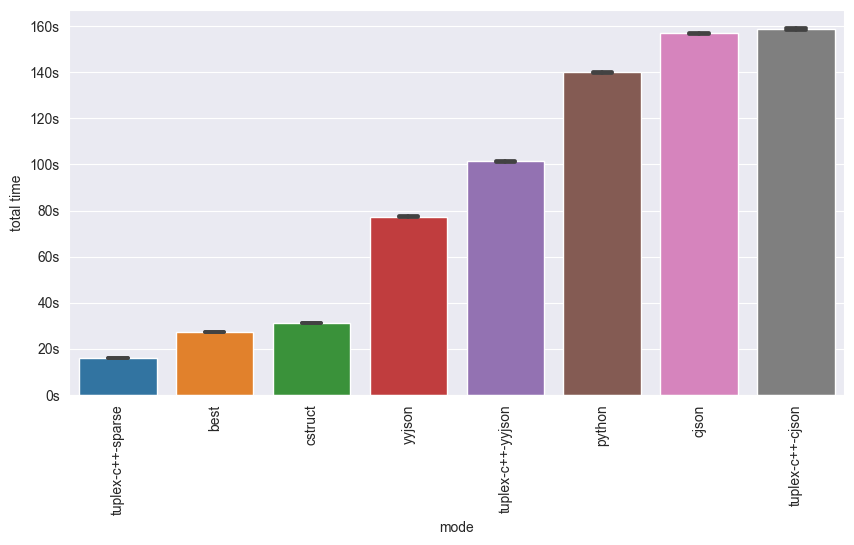

In [7]:
plot_total_time(df)

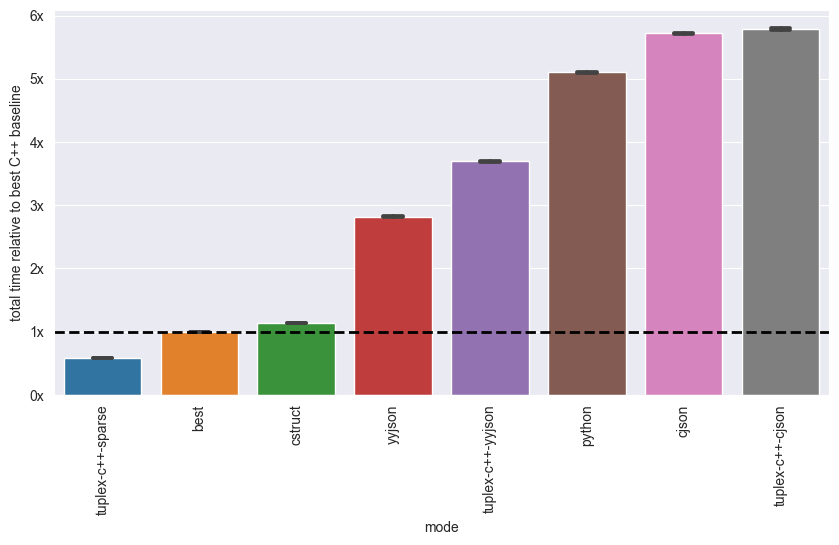

In [8]:
plot_total_time(df, True)

In [9]:
df[df['mode'] == 'tuplex-c++-sparse']['total_time_in_s'].mean()

16.151292333333338

In [10]:
df[df['mode'] == 'python']['total_time_in_s'].mean()

139.93298208713531

In [11]:
def plot_per_file_runtimes(df, modes=['best', 'python'], normalize_to=None):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    df = df[df['mode'].isin(modes)]
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    normalized_best_label = f'time_factor_compared_to_{normalize_to}'
    
    if normalize_to is not None:
        def helper(g):
            g[normalized_best_label] = g['time_in_s'] / g[g['mode'] == normalize_to]['time_in_s'].mean()
            return g
        df = df.groupby(['input_path'], group_keys=False).apply(helper)
    
    sns.barplot(df.sort_values(by=['time_in_s']), x='input_path',
                y=normalized_best_label if normalize_to is not None else 'time_in_s',
                hue='mode', errorbar=None, capsize=0)
    plt.xticks(rotation=90)
    
    if normalize_to is None:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('time per file')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

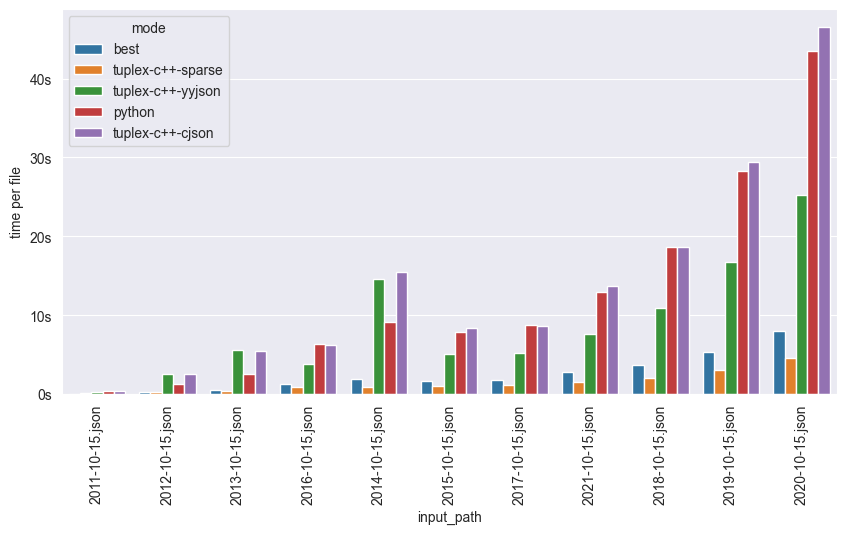

In [12]:
select_modes = ['best', 'tuplex-c++-sparse', 'tuplex-c++-yyjson', 'tuplex-c++-cjson', 'python']
plot_per_file_runtimes(df, modes=select_modes)

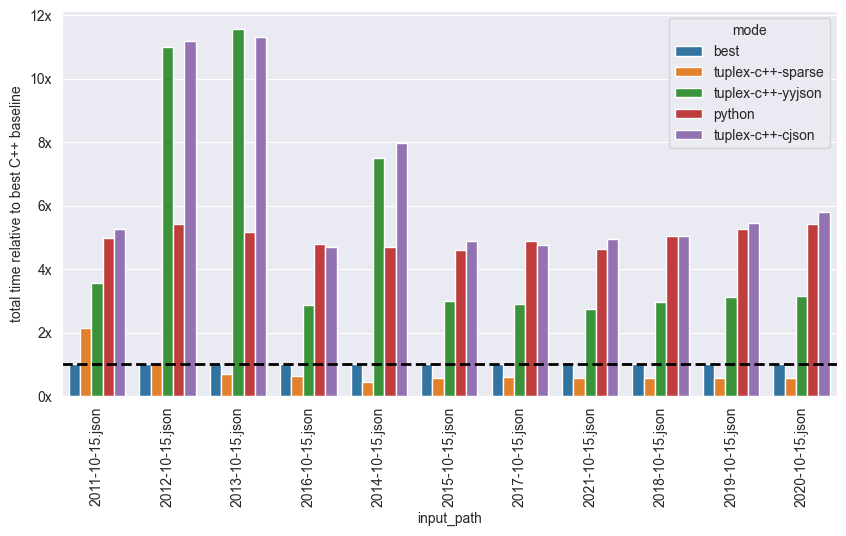

In [13]:
plot_per_file_runtimes(df, modes=select_modes, normalize_to='best')